In [23]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from loader import hetero_graph_loader
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
from graph_plotting import graph_2D
from utils import prep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:

octa_dr_dict = {"Healthy": 0, "DM": 1, "PDR": 4, "Early NPDR": 2, "Late NPDR": 3}
label_names = ["Healthy/DM", "NPDR", "PDR"]

data_type = "DCP"

vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"





mode_train = "train"
train_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_train}_dataset.pkl"
train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_train,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = train_pickle
                                                        )

mode_test = "test"
test_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_test}_dataset.pkl"
test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_test,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = test_pickle
                                                        )

# from loaded files, ensure that the classes are set properly
train_dataset.update_class(octa_dr_dict)
test_dataset.update_class(octa_dr_dict)


# imputation and normalization
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

prep.add_node_features(train_dataset, ["graph_1", "graph_2"])
prep.add_node_features(test_dataset, ["graph_1", "graph_2"])

#prep.add_global_node(train_dataset)
#prep.add_global_node(test_dataset)


node_mean_tensors, node_std_tensors = prep.hetero_graph_normalization_params(train_dataset)
#node_mean_tensors = torch.load(f"../{data_type}_node_mean_tensors_global_node_node_degs.pt")
#node_std_tensors = torch.load(f"../{data_type}_node_std_tensors_global_node_node_degs.pt")

#print(node_mean_tensors)
#print(node_std_tensors)

#node_mean_tensors = torch.load(f"checkpoints/{data_type}_node_mean_tensors_global_node_node_degs.pt")
#node_std_tensors = torch.load(f"checkpoints/{data_type}_node_std_tensors_global_node_node_degs.pt")

prep.hetero_graph_normalization(train_dataset, node_mean_tensors, node_std_tensors)
prep.hetero_graph_normalization(test_dataset, node_mean_tensors, node_std_tensors)


In [25]:
# read the label_dict.json

with open("../label_dict.json", "r") as file:
    features_label_dict = json.load(file)


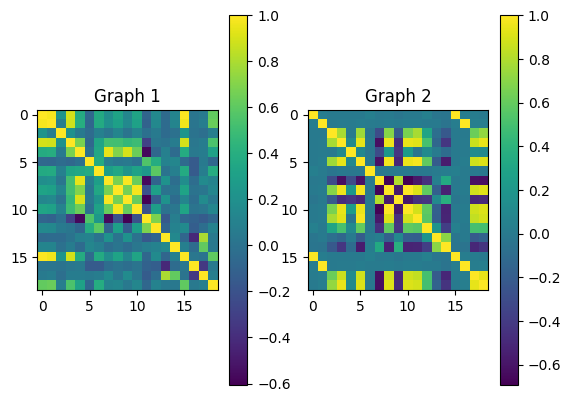

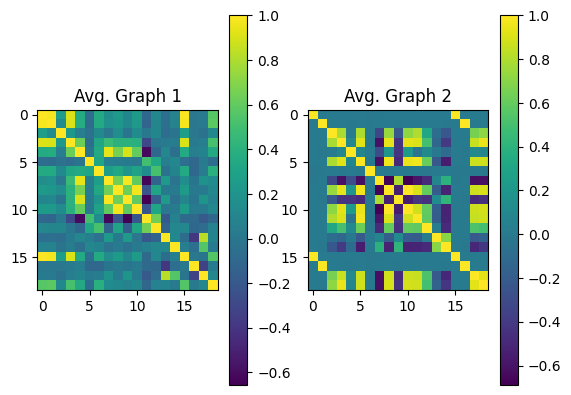

Graph 1
length distance
Correlation Value: 0.9800121784210205
length num_voxels
Correlation Value: 0.9918382167816162
distance num_voxels
Correlation Value: 0.970060408115387
avgRadiusAvg maxRadiusAvg
Correlation Value: 0.9867037534713745
avgRadiusStd maxRadiusStd
Correlation Value: 0.9703113436698914
Graph 2
########################################
centroid-0 centroid_weighted-0
Correlation Value: 0.9999787211418152
centroid-1 centroid_weighted-1
Correlation Value: 0.9999763369560242
equivalent_diameter feret_diameter_max
Correlation Value: 0.9661771059036255
equivalent_diameter axis_minor_length
Correlation Value: 0.9715129733085632
feret_diameter_max axis_major_length
Correlation Value: 0.994637131690979


In [26]:
# correlation analysis of the features

# iterate over all graphs in the training set and compute the correlation matrix
# for each graph
correlation_matrices = []

corr_graph_1 = None
corr_graph_2 = None

num_samp = len(train_dataset)

for i in range(len(train_dataset)):
    graph_1 = train_dataset[i]["graph_1"]
    graph_2 = train_dataset[i]["graph_2"]
    
    # torch corrcoef if none, otherwise add to the matrix
    corr_graph_1 = torch.corrcoef(graph_1.x.T) if corr_graph_1 is None else corr_graph_1 + torch.corrcoef(graph_1.x.T)
    # remove the diagonal
    #corr_graph_1 = corr_graph_1 - torch.diag(torch.diag(corr_graph_1))
    corr_graph_2 = torch.corrcoef(graph_2.x.T) if corr_graph_2 is None else corr_graph_2 + torch.corrcoef(graph_2.x.T)
    # remove the diagonal
    #corr_graph_2 = corr_graph_2 - torch.diag(torch.diag(corr_graph_2))

    if i ==0:
    ## plot the correlation matrices with imshow and numbers for the correlation values
        fig, ax = plt.subplots(1,2)
        pos = ax[0].imshow(corr_graph_1)
        ax[0].set_title("Graph 1")
        # add colorbar
        fig.colorbar(pos, ax=ax[0])
        pos = ax[1].imshow(corr_graph_2)
        ax[1].set_title("Graph 2")
        fig.colorbar(pos, ax=ax[1])

    

    #break
corr_graph_1 /= num_samp
corr_graph_2 /= num_samp

fig, ax = plt.subplots(1,2)
pos = ax[0].imshow(corr_graph_1)
ax[0].set_title("Avg. Graph 1")
# add colorbar
fig.colorbar(pos, ax=ax[0])
pos = ax[1].imshow(corr_graph_2)
ax[1].set_title("Avg. Graph 2")
fig.colorbar(pos, ax=ax[1])

plt.show()
plt.close()

# print pairs of features that are highly correlated (corr > 0.9)
corr_threshold = 0.95
corr_graph_1 = corr_graph_1.numpy()
corr_graph_2 = corr_graph_2.numpy()

corr_graph_1_u = np.triu(corr_graph_1, k=1)
corr_graph_2_u = np.triu(corr_graph_2, k=1)

corr_graph_1_sc = np.where(corr_graph_1_u > corr_threshold)
corr_graph_2_sc = np.where(corr_graph_2_u > corr_threshold)

print("Graph 1")
for i in range(len(corr_graph_1_sc[0])):
    print(features_label_dict["graph_1"][corr_graph_1_sc[0][i]], features_label_dict["graph_1"][corr_graph_1_sc[1][i]])
    print(f"Correlation Value: {corr_graph_1[corr_graph_1_sc[0][i], corr_graph_1_sc[1][i]]}")
print("Graph 2")
print("#"*40)
for i in range(len(corr_graph_2_sc[0])):
    print(features_label_dict["graph_2"][corr_graph_2_sc[0][i]], features_label_dict["graph_2"][corr_graph_2_sc[1][i]])
    print(f"Correlation Value: {corr_graph_2[corr_graph_2_sc[0][i], corr_graph_2_sc[1][i]]}")

## print all features
#print("Graph 1")
#for i in range(len(features_label_dict["graph_1"])):
#    print(features_label_dict["graph_1"][i])
#print("Graph 2")
#print("#"*40) 
#for i in range(len(features_label_dict["graph_2"])):
#    print(features_label_dict["graph_2"][i])

torch.Size([900, 1])
torch.Size([900, 19])
torch.Size([900, 19])


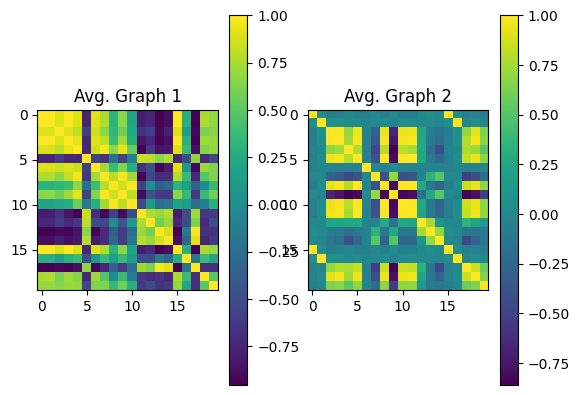

Graph 1
Avg.length 0.69409174
Avg.distance 0.6941513
Avg.curveness 0.6457244
Avg.volume 0.6988782
Avg.avgCrossSection 0.6893355
Avg.minRadiusAvg -0.5361214
Avg.minRadiusStd 0.63480705
Avg.avgRadiusAvg 0.6268405
Avg.avgRadiusStd 0.35020757
Avg.maxRadiusAvg 0.57019836
Avg.maxRadiusStd 0.27195585
Avg.roundnessAvg -0.6232459
Avg.roundnessStd -0.490266
Avg.node1_degree -0.6659765
Avg.node2_degree -0.6238879
Avg.num_voxels 0.693581
Avg.hasNodeAtSampleBorder 0.19963773
Avg.degree -0.67444557
Avg.hetero_degree 0.49844474
Graph 2
########################################
Avg.centroid-0 -0.08292216
Avg.centroid-1 -0.0074209166
Avg.area 0.6370056
Avg.perimeter 0.66472554
Avg.eccentricity 0.52599597
Avg.equivalent_diameter 0.69396025
Avg.orientation -0.008031238
Avg.solidity -0.2007048
Avg.feret_diameter_max 0.6872403
Avg.extent -0.5331665
Avg.axis_major_length 0.6840869
Avg.axis_minor_length 0.6981316
Avg.intensity_max 0.13137574
Avg.intensity_mean -0.088553965
Avg.intensity_min -0.11858093
Avg.ce

In [27]:
correlation_matrices = []

corr_graph_1 = None
corr_graph_2 = None

num_samp = len(train_dataset)

graph_1_corr = torch.zeros((len(train_dataset), len(features_label_dict["graph_1"])))
graph_2_corr = torch.zeros((len(train_dataset), len(features_label_dict["graph_2"])))

label_tensor = torch.zeros((len(train_dataset), 1))

for i in range(len(train_dataset)):
    graph_1 = train_dataset[i]["graph_1"]
    graph_2 = train_dataset[i]["graph_2"]

    label_tensor[i] = train_dataset[i].y
    
    # average the features of all nodes in the graph 
    graph_1_avg = torch.mean(graph_1.x, dim=0)
    graph_2_avg = torch.mean(graph_2.x, dim=0)

    # add averages to the matrix
    graph_1_corr[i] = graph_1_avg
    graph_2_corr[i] = graph_2_avg

print(label_tensor.shape)
print(graph_1_corr.shape)
print(graph_2_corr.shape)


# calculate the correlation matrix for the average features with the labels
graph_1_corr = torch.cat((graph_1_corr, label_tensor), dim=1)
graph_2_corr = torch.cat((graph_2_corr, label_tensor), dim=1)

corr_graph_1 = torch.corrcoef(graph_1_corr.T)
corr_graph_2 = torch.corrcoef(graph_2_corr.T)

fig, ax = plt.subplots(1,2)
pos = ax[0].imshow(corr_graph_1)
ax[0].set_title("Avg. Graph 1")
# add colorbar
fig.colorbar(pos, ax=ax[0])
pos = ax[1].imshow(corr_graph_2)
ax[1].set_title("Avg. Graph 2")
fig.colorbar(pos, ax=ax[1])

plt.show()
plt.close()

# print correlations of the average features with the labels

corr_graph_1 = corr_graph_1.numpy()
corr_graph_2 = corr_graph_2.numpy()

print("Graph 1")
for i in range(len(corr_graph_1)-1):
    print("Avg." + features_label_dict["graph_1"][i], corr_graph_1[i, -1])
print("Graph 2")
print("#"*40)
for i in range(len(corr_graph_2)-1):
    print("Avg." + features_label_dict["graph_2"][i], corr_graph_2[i, -1])


print("#"*40)
# print features that are highly correlated among themselves
corr_threshold = 0.99
corr_graph_1_u = np.triu(corr_graph_1, k=1)
corr_graph_2_u = np.triu(corr_graph_2, k=1)

corr_graph_1_sc = np.where(corr_graph_1_u > corr_threshold)
corr_graph_2_sc = np.where(corr_graph_2_u > corr_threshold)

print("Graph 1")
for i in range(len(corr_graph_1_sc[0])):
    print("Avg." + features_label_dict["graph_1"][corr_graph_1_sc[0][i]], "Avg." + features_label_dict["graph_1"][corr_graph_1_sc[1][i]])
    print(f"Correlation Value: {corr_graph_1[corr_graph_1_sc[0][i], corr_graph_1_sc[1][i]]}")

print("Graph 2")
print("#"*40)
for i in range(len(corr_graph_2_sc[0])):
    print("Avg." + features_label_dict["graph_2"][corr_graph_2_sc[0][i]], "Avg." + features_label_dict["graph_2"][corr_graph_2_sc[1][i]])
    print(f"Correlation Value: {corr_graph_2[corr_graph_2_sc[0][i], corr_graph_2_sc[1][i]]}")


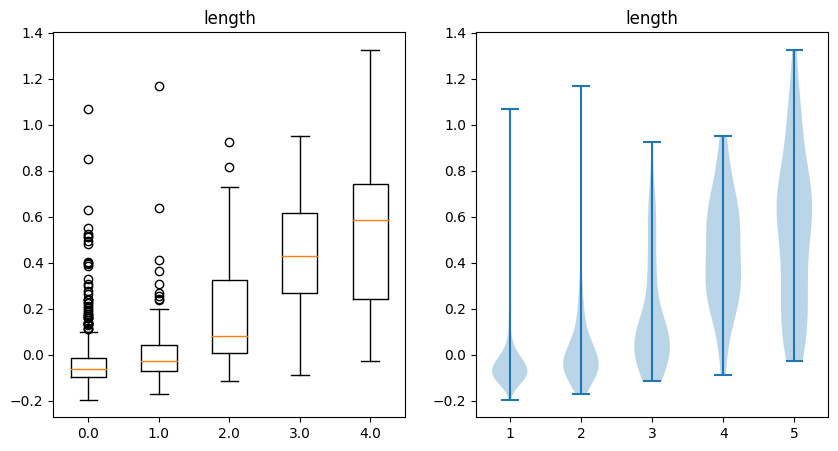

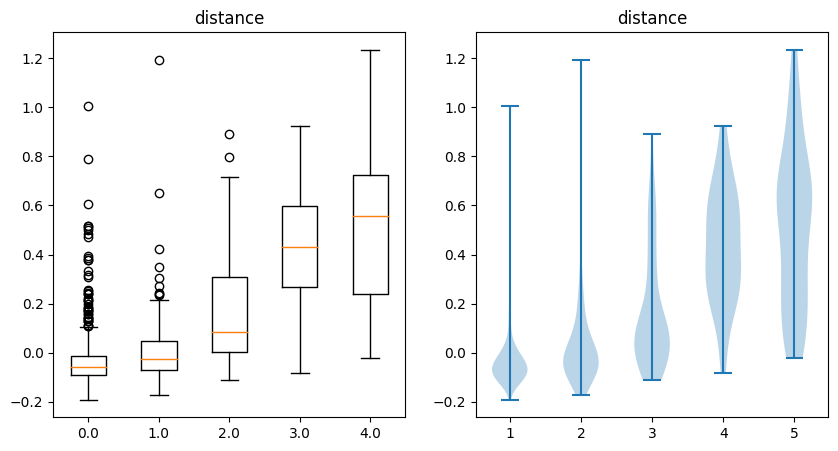

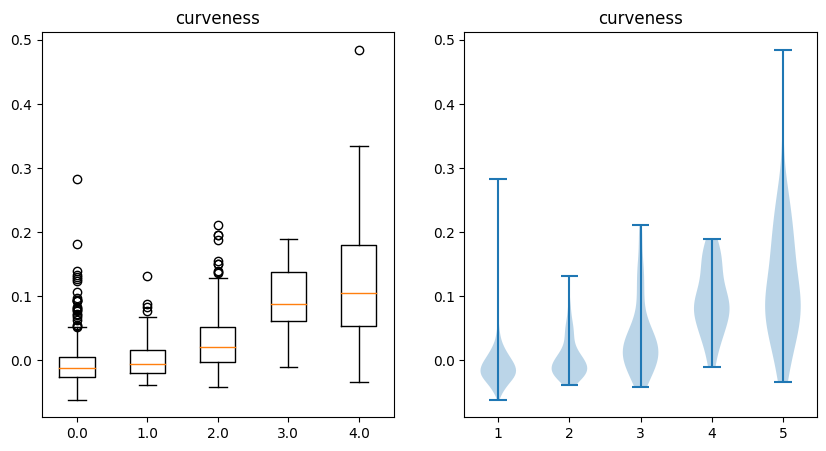

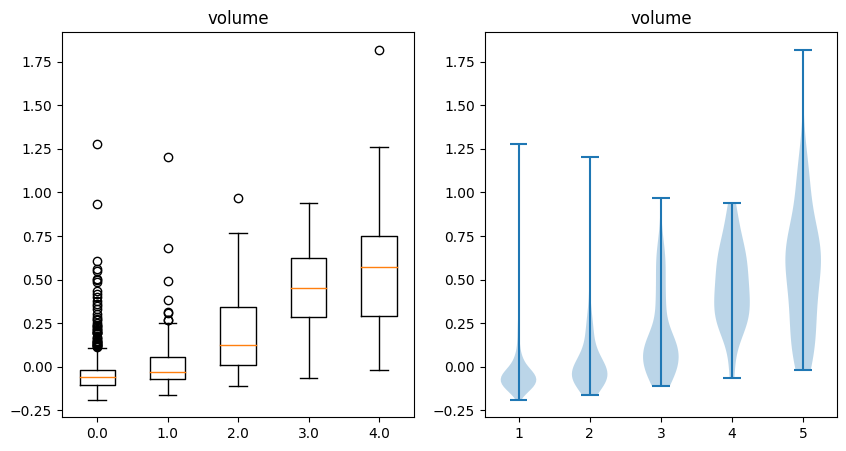

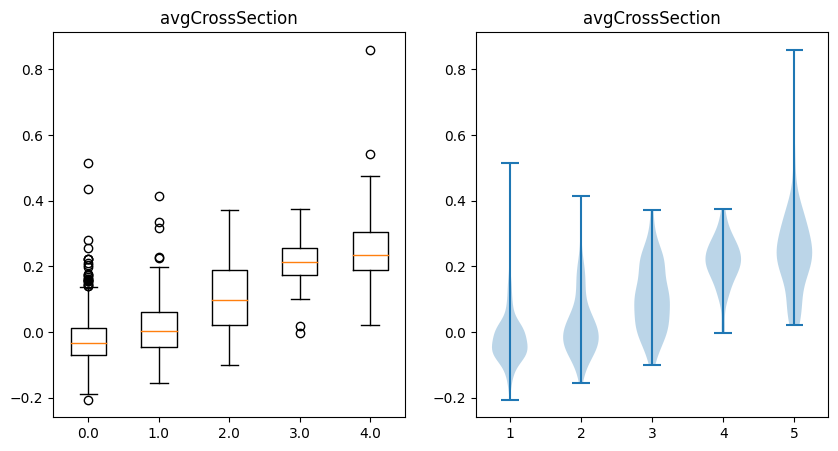

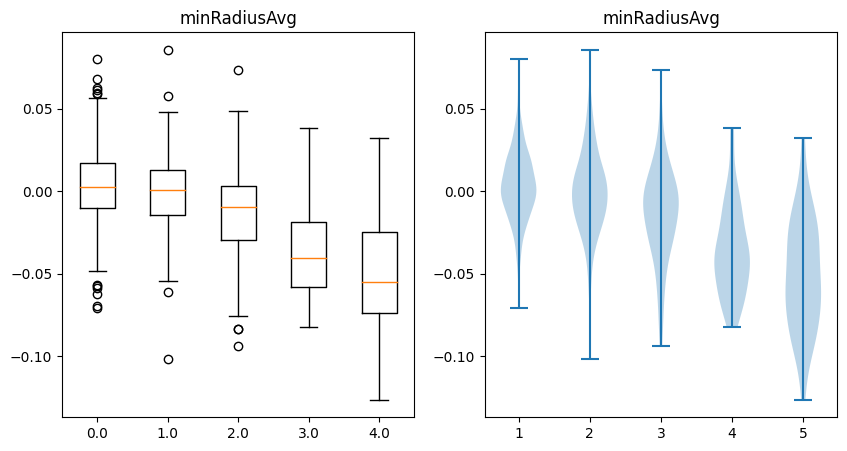

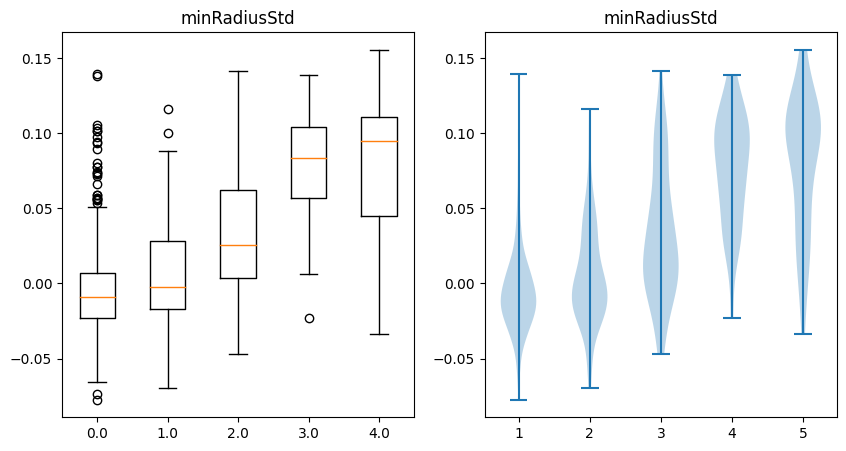

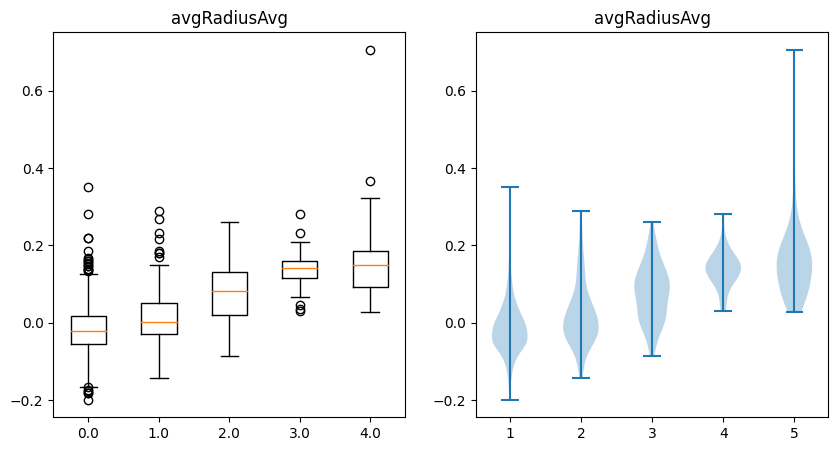

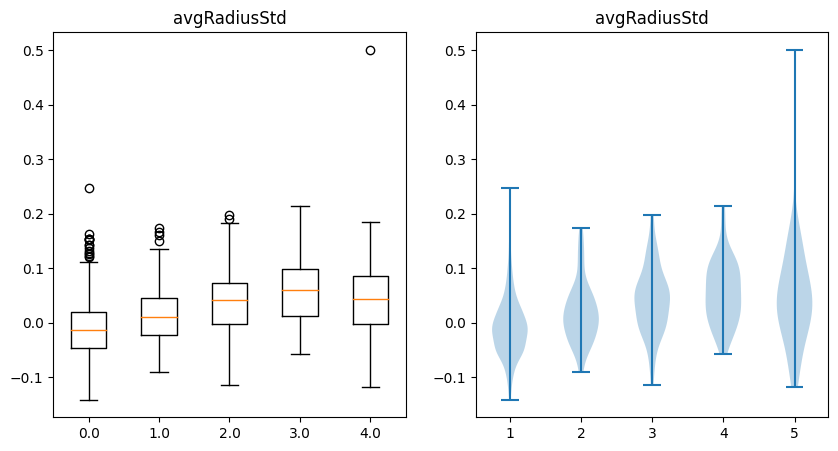

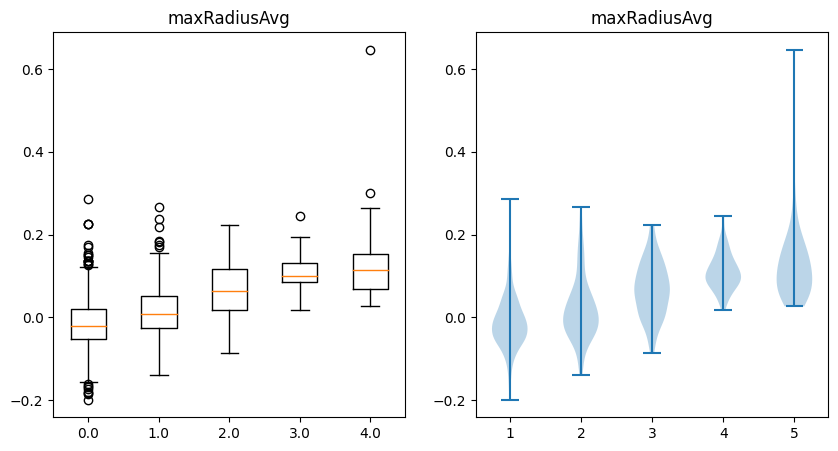

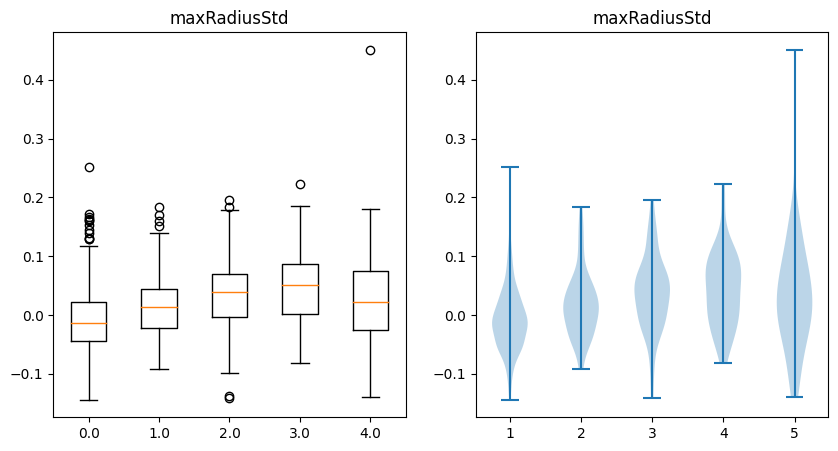

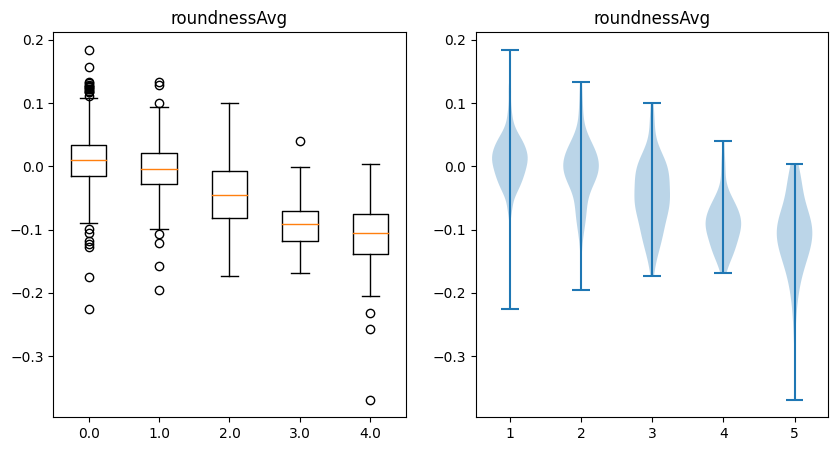

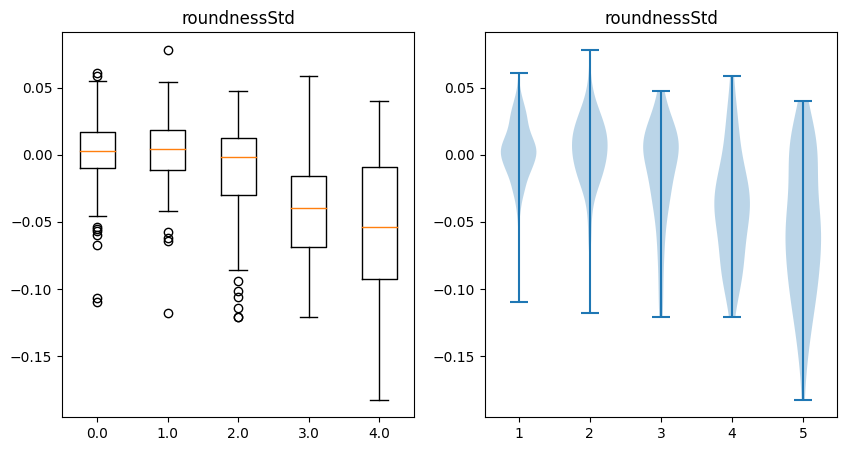

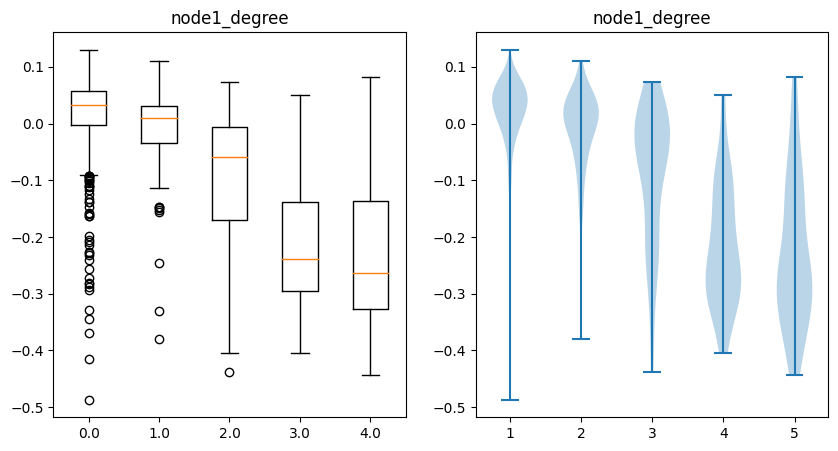

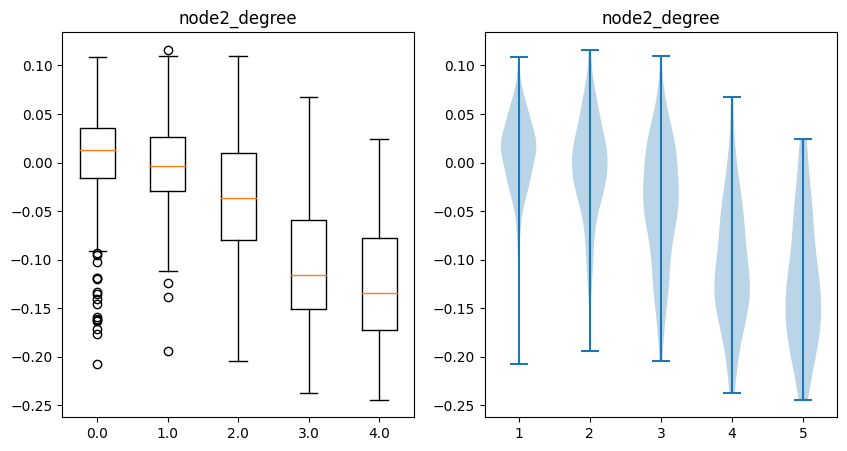

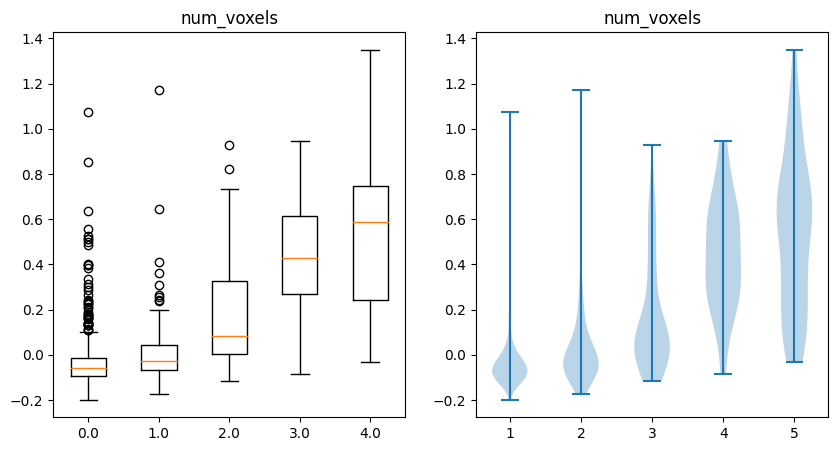

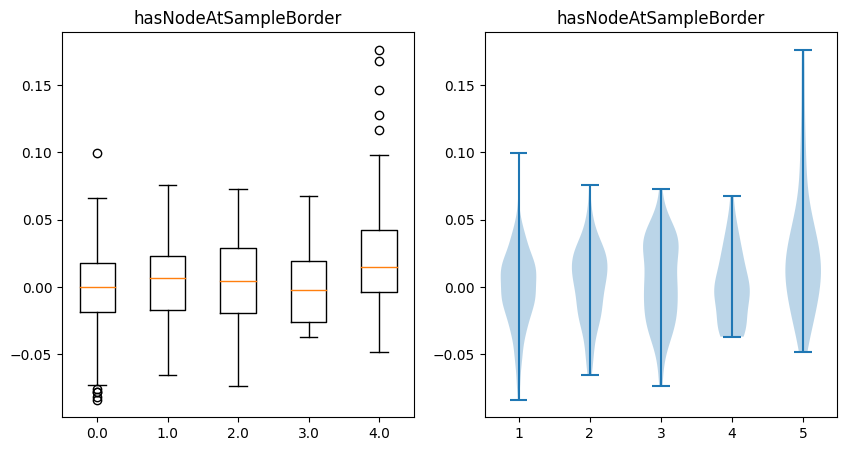

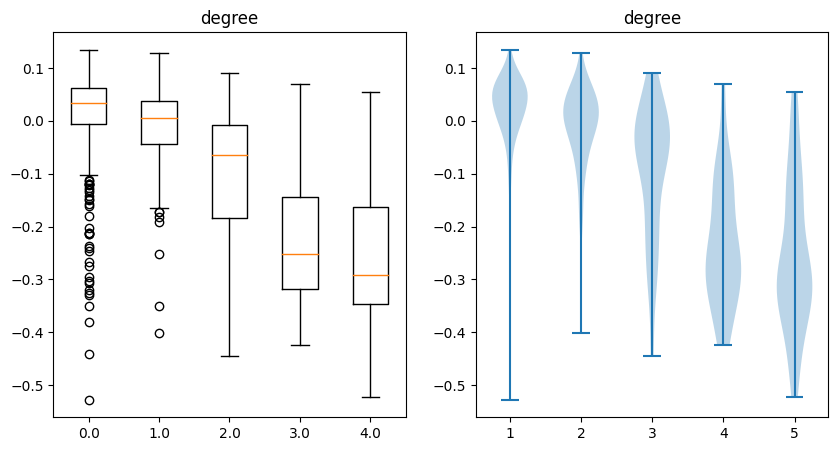

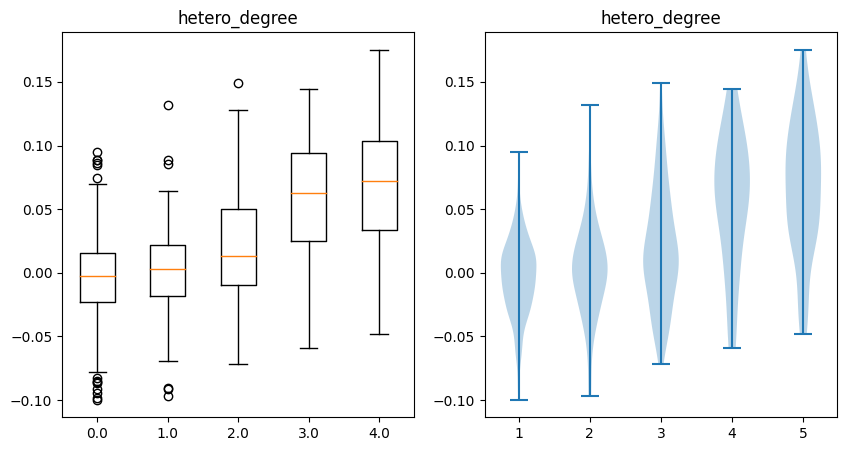

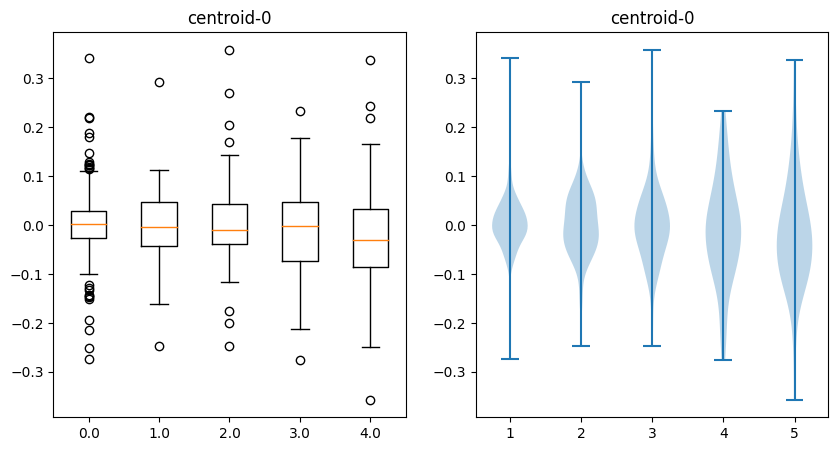

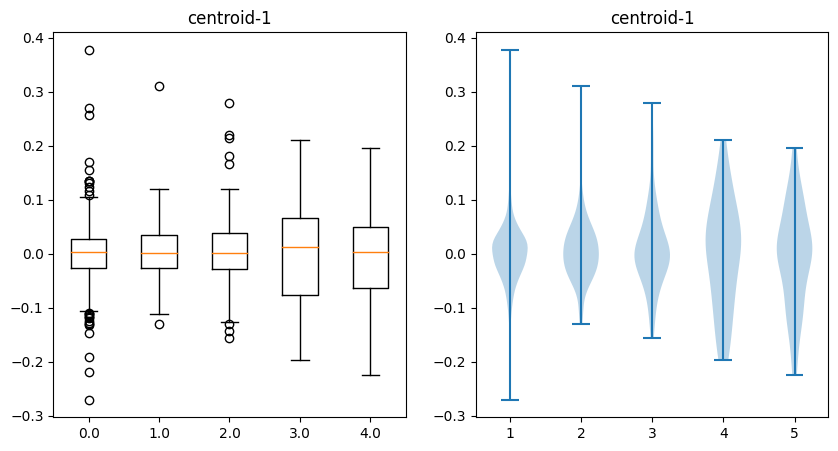

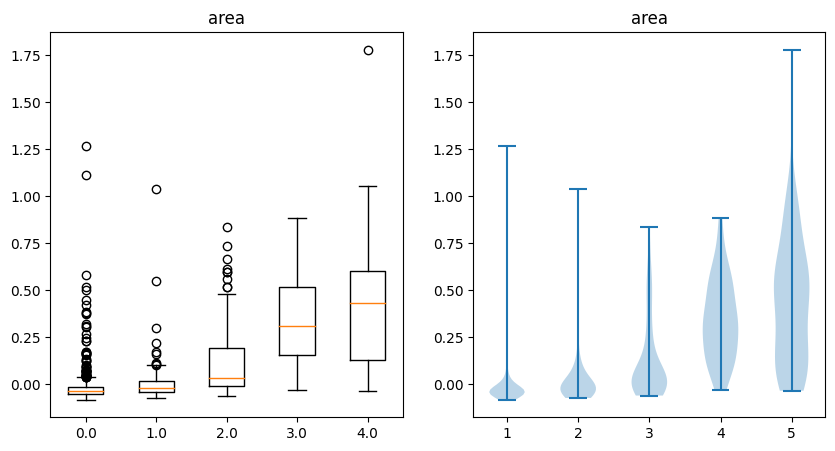

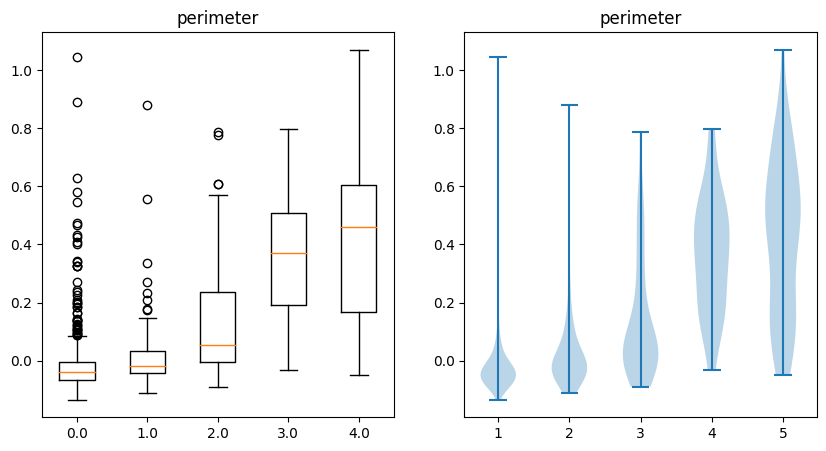

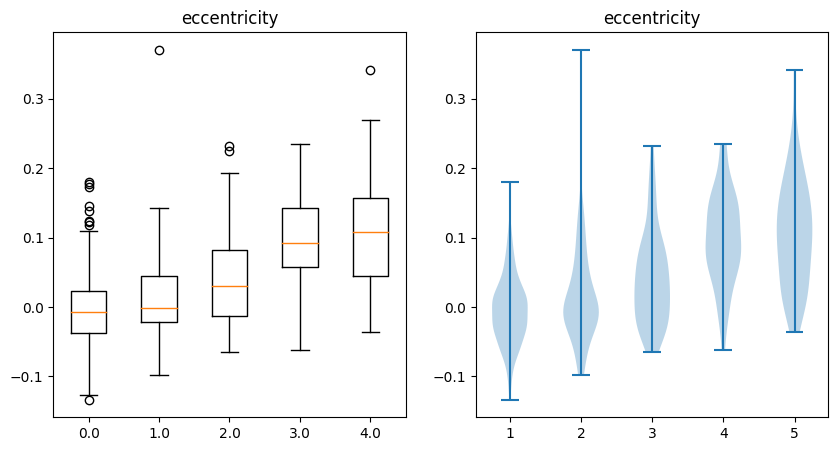

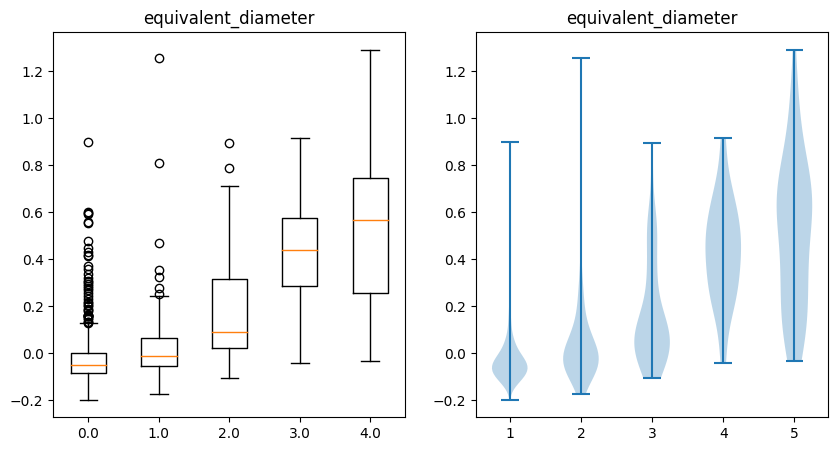

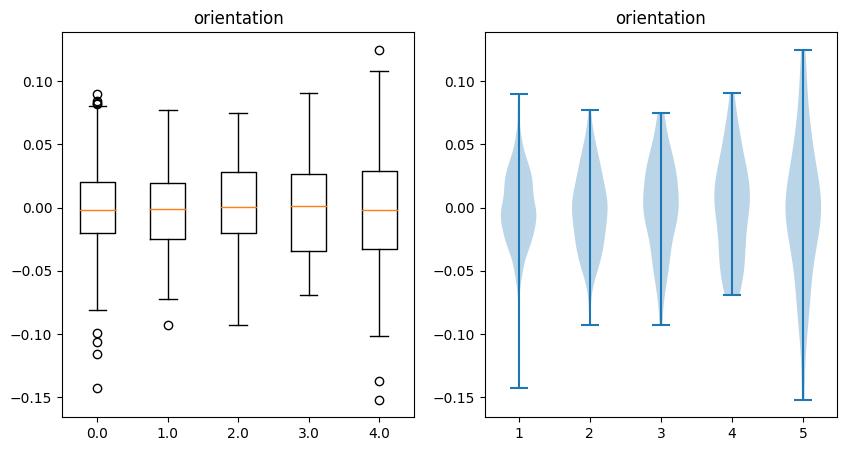

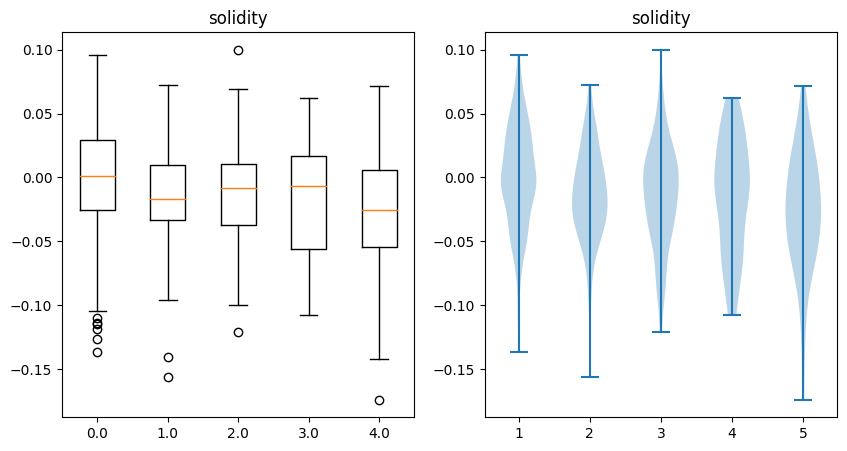

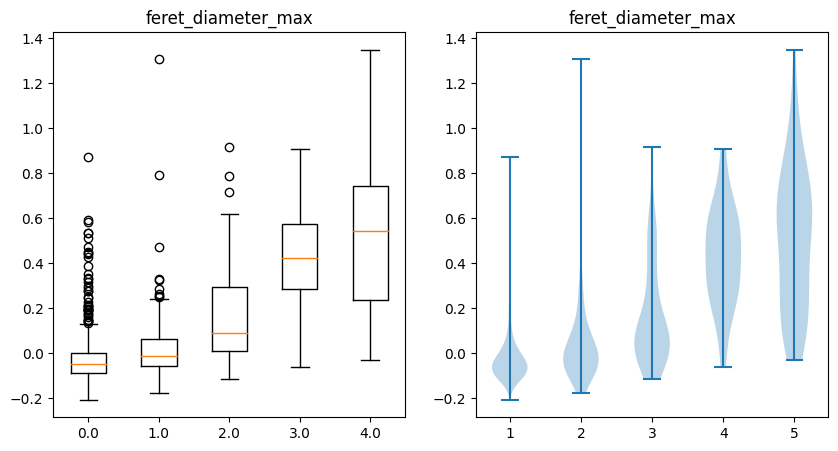

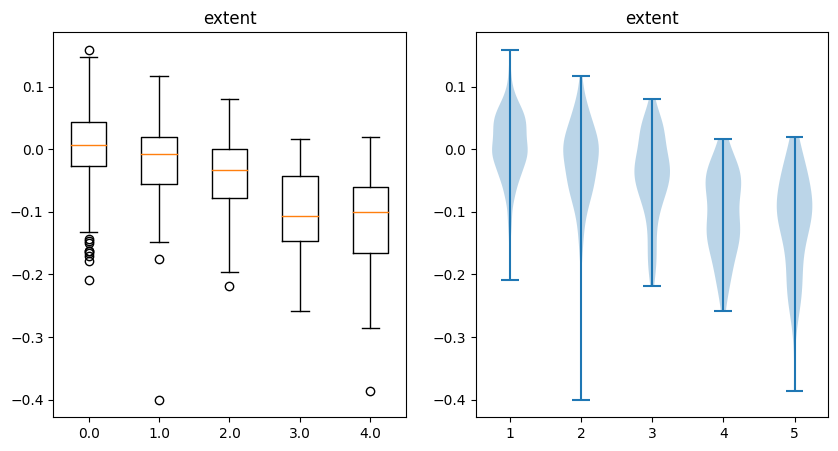

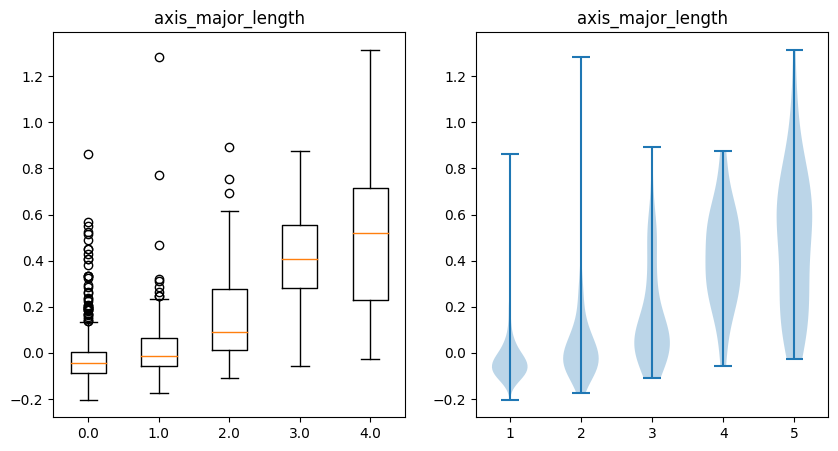

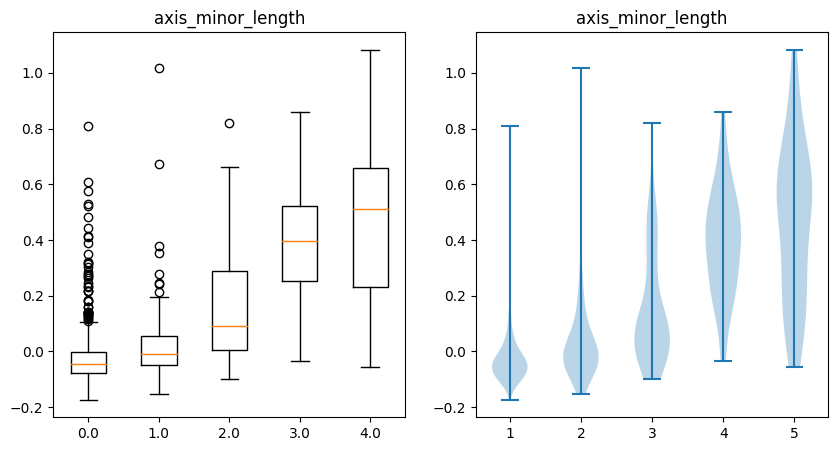

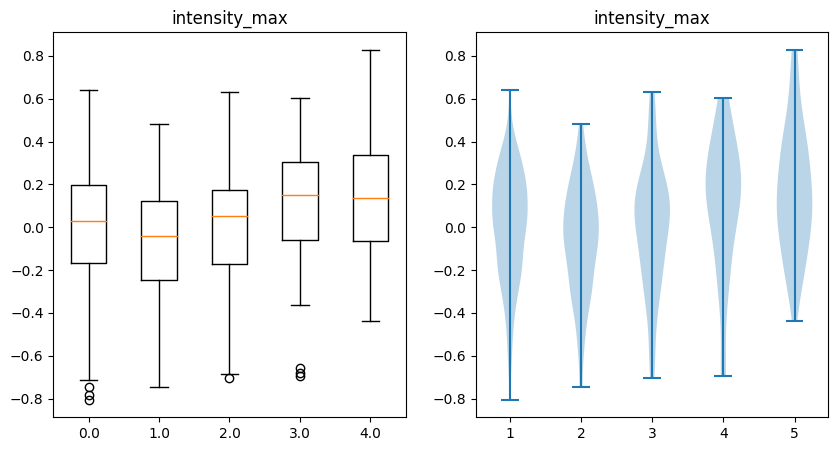

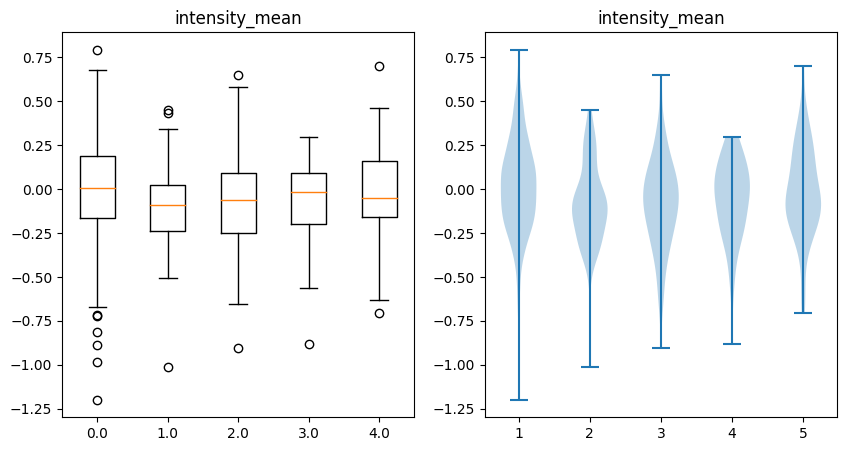

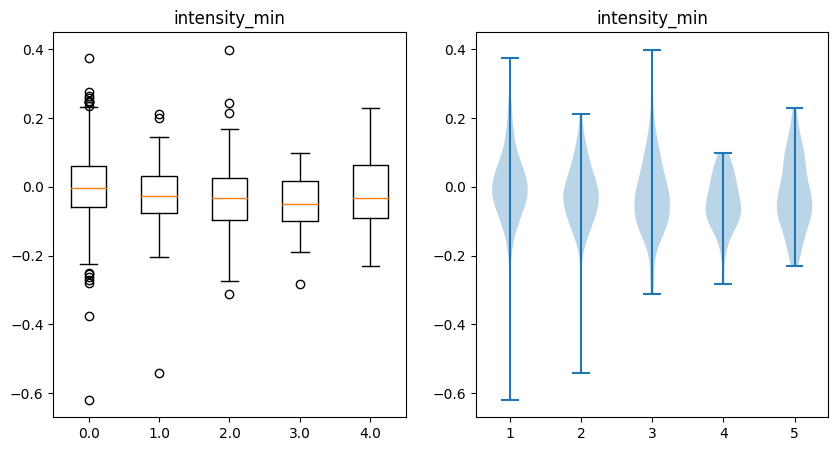

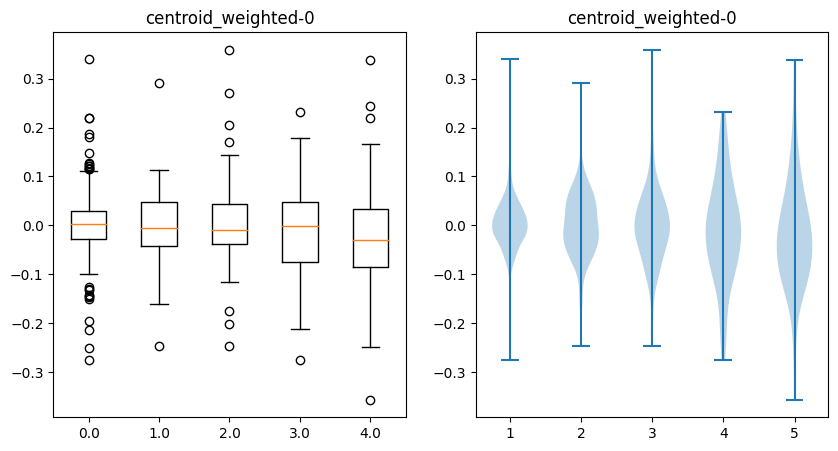

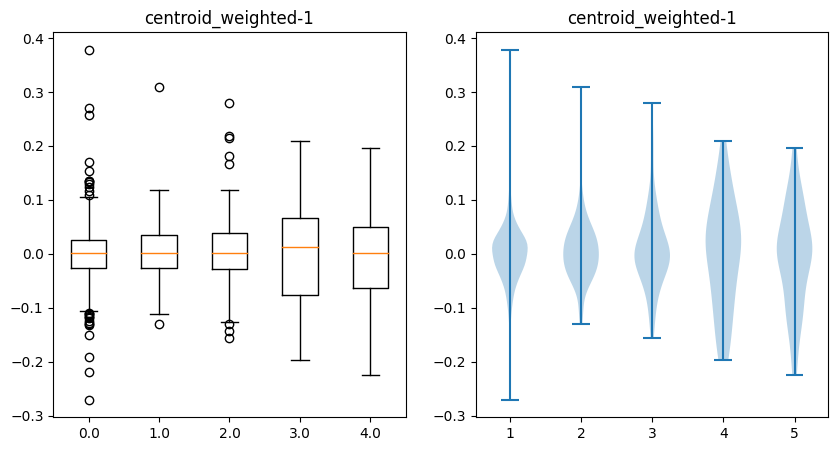

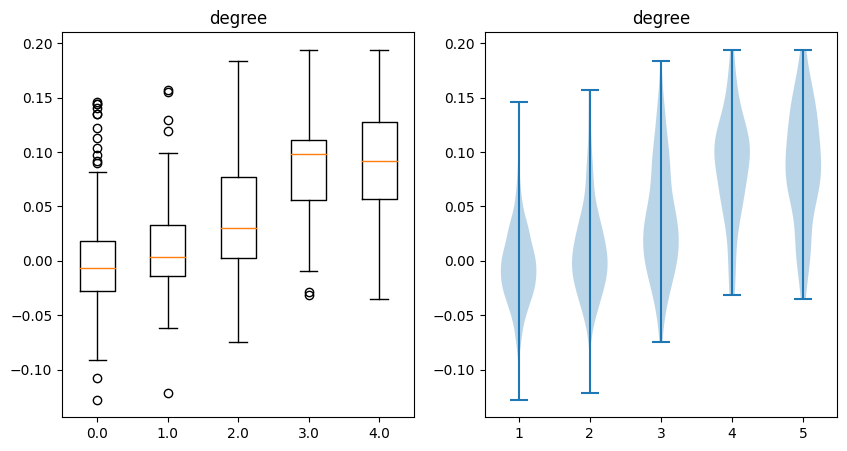

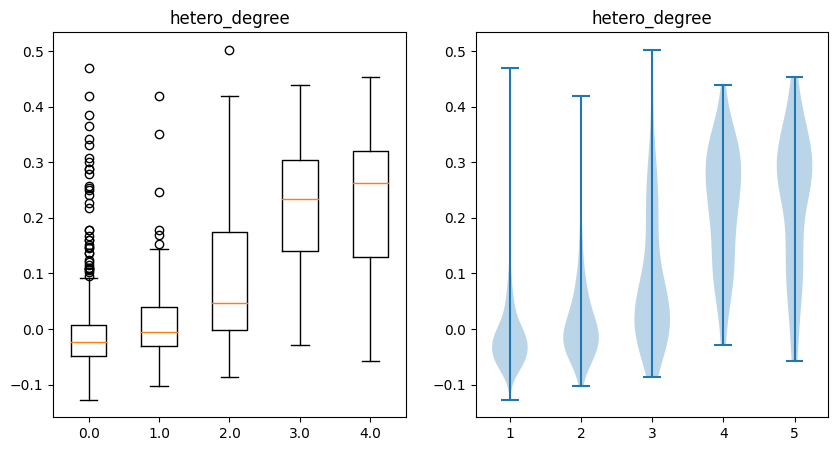

In [36]:
# boxplot for a highly correlated feature on the x axis and the label on the y axis

# get the index of the feature
feature_idx = 1
feature_name = features_label_dict["graph_1"][feature_idx]

# get the feature values for all graphs
feature_values = graph_1_corr[:, feature_idx].numpy()
label_values = graph_1_corr[:, -1].numpy()

def plot_boxplot(feature_values, label_values, feature_name):
    # group the feature values by label
    grouped_data = [feature_values[label_values == label] for label in set(label_values)]

    # plot the boxplot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].boxplot(grouped_data, labels=set(label_values))
    ax[0].set_title(feature_name)
    ax[1].violinplot(grouped_data)
    ax[1].set_title(feature_name)
    plt.show()
    plt.close()

for idx in range(len(features_label_dict["graph_1"])):
    feature_name = features_label_dict["graph_1"][idx]
    feature_values = graph_1_corr[:, idx].numpy()
    plot_boxplot(feature_values, label_values, feature_name)

# plot for graph 2 features

for idx in range(len(features_label_dict["graph_2"])):
    feature_name = features_label_dict["graph_2"][idx]
    feature_values = graph_2_corr[:, idx].numpy()
    plot_boxplot(feature_values, label_values, feature_name)




NameError: name 'test_dataset_DCP' is not defined

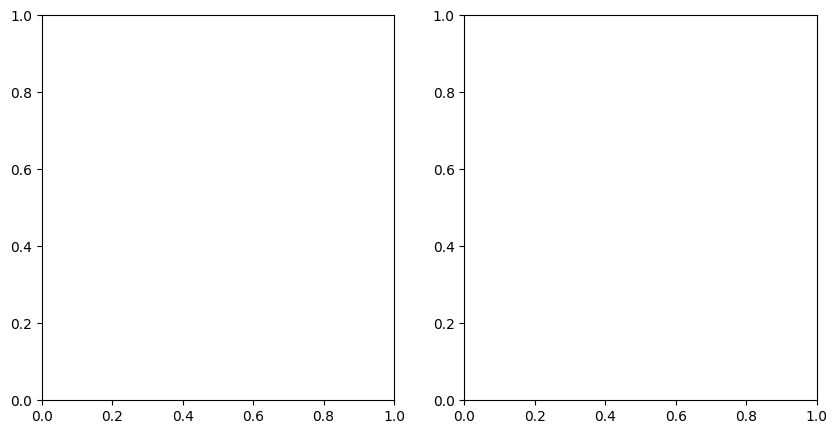

In [30]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
graph_2D.HeteroGraphPlotter2D().plot_graph_2D(test_dataset_DCP.hetero_graphs["0533_OS"], edges= True, ax=ax[0])
graph_2D.HeteroGraphPlotter2D().plot_graph_2D(test_dataset_SCP.hetero_graphs["0533_OS"], edges= True, ax=ax[1])

# dcp is way denser than scp

In [ ]:

node_tensors = {}
node_mean_tensors = {}
node_std_tensors = {}
for key, val in train_dataset.hetero_graph_list[0].x_dict.items():
    node_tensors[key] = None

for data in train_dataset:
    for key, val in data.x_dict.items():
        node_tensors[key] = torch.cat([node_tensors[key], val]) if node_tensors[key] is not None else val

for key, val in node_tensors.items():
    node_mean_tensors[key] = torch.mean(val, dim=0)
    node_std_tensors[key] = torch.std(val, dim=0)


/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/matplotlib/mlab.py:978: RuntimeWarning: invalid value encountered in subtract
  diff = self.dataset - points[:, i, np.newaxis]
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


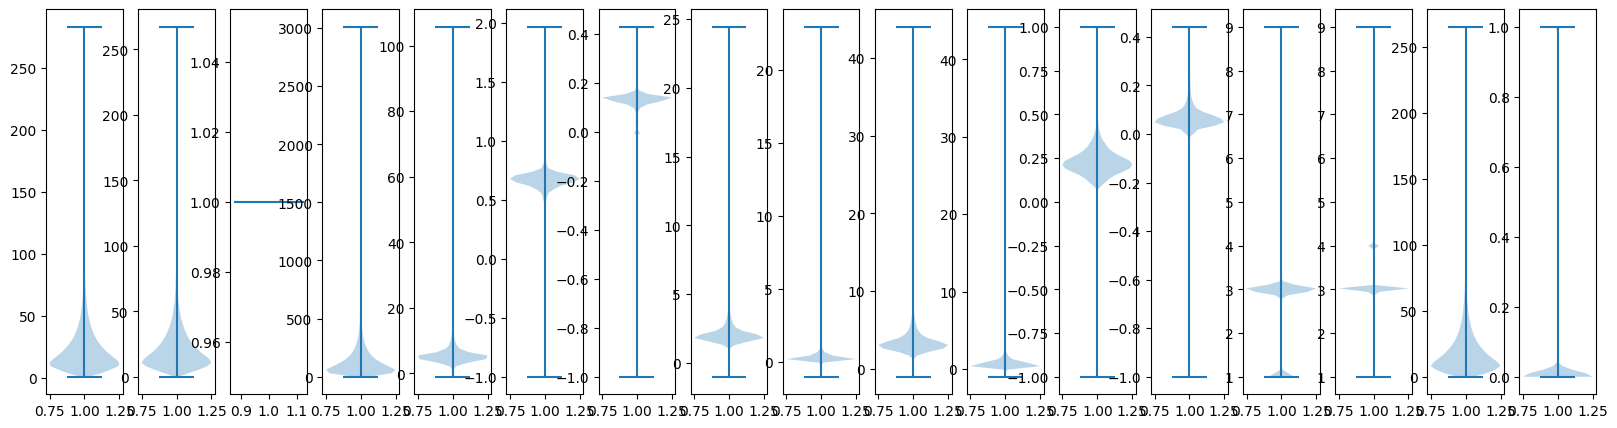

In [ ]:
# use violin plots to show the distribution of the features

# select 10% of the data at random

np.random.seed(42)
indices = np.random.choice(node_tensors["graph_1"].shape[0], int(node_tensors["graph_1"].shape[0] * 0.1), replace=False)
example_fraction = node_tensors["graph_1"][indices, :]

# plot distributions for all node features
fig, axs = plt.subplots(1, example_fraction.shape[1], figsize=(20, 5))

for i in range(example_fraction.shape[1]):
    axs[i].violinplot(example_fraction[:, i])

plt.show()



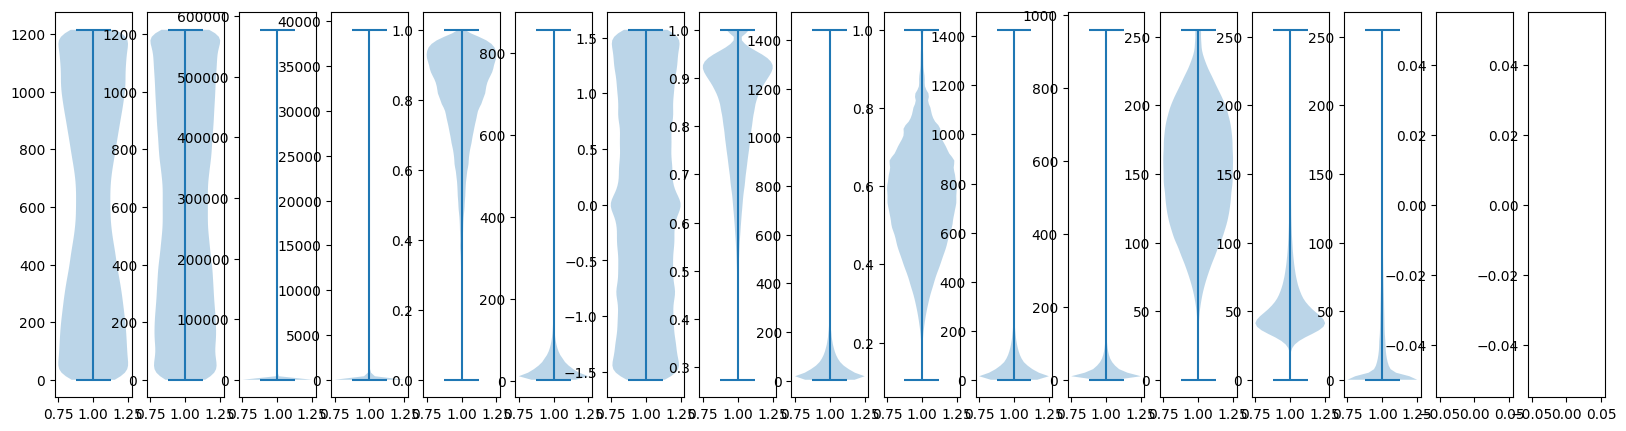

In [ ]:
# use violin plots to show the distribution of the features


# plot distributions for all node features
fig, axs = plt.subplots(1, node_tensors["graph_2"].shape[1], figsize=(20, 5))

for i in range(node_tensors["graph_2"].shape[1]):
    axs[i].violinplot(node_tensors["graph_2"][:, i])

plt.show()

In [ ]:
nan_pos = torch.where(torch.isinf(node_tensors["graph_2"]))
nan_pos

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))

In [ ]:
node_tensors["graph_2"][:, 16].nanmean()

tensor(615.5863)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f4dac15bcd0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f4dac0ad2a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f4db1e7e8f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f4db1e91f90>}

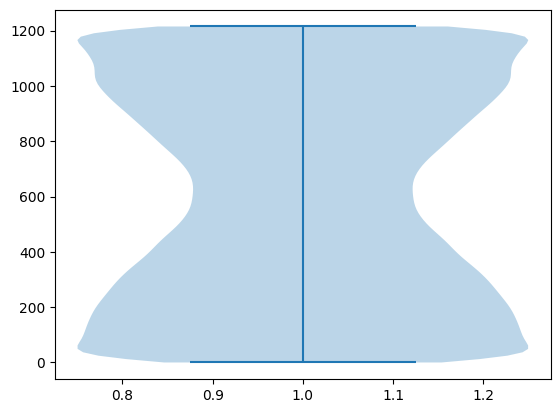

In [ ]:
plt.violinplot(node_tensors["graph_2"][:, 15])